
# TOF listmode OSEM with projection data

This example demonstrates the use of the listmode OSEM algorithm to minimize the negative Poisson log-likelihood function.

\begin{align}f(x) = \sum_{i=1}^m \bar{y}_i (x) - \bar{y}_i (x) \log(y_i)\end{align}

subject to

\begin{align}x \geq 0\end{align}

using the listmode linear forward model

\begin{align}\bar{y}_{LM}(x) = A_{LM} x + s\end{align}

and data stored in listmode format (event by event).

.. tip::
    parallelproj is python array API compatible meaning it supports different 
    array backends (e.g. numpy, cupy, torch, ...) and devices (CPU or GPU).
    Choose your preferred array API ``xp`` and device ``dev`` below.

<img src="https://mybinder.org/badge_logo.svg" target="https://mybinder.org/v2/gh/gschramm/parallelproj/master?labpath=examples">


In [1]:
from __future__ import annotations
from array_api_strict._array_object import Array

# import array_api_compat.numpy as xp

import array_api_compat.cupy as xp
# import array_api_compat.torch as xp

import parallelproj
from array_api_compat import to_device, size
import array_api_compat.numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy

# choose a device (CPU or CUDA GPU)
if "numpy" in xp.__name__:
    # using numpy, device must be cpu
    dev = "cpu"
elif "cupy" in xp.__name__:
    # using cupy, only cuda devices are possible
    dev = xp.cuda.Device(0)
elif "torch" in xp.__name__:
    # using torch valid choices are 'cpu' or 'cuda'
    if parallelproj.cuda_present:
        dev = "cuda"
    else:
        dev = "cpu"


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /home/pablo/anaconda3/envs/recon/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /home/pablo/anaconda3/envs/recon/lib/libparallelproj_cuda.so.1.8.0
    


## Simulation of PET data in sinogram space

In this example, we use simulated listmode data for which we first
need to setup a sinogram forward model to create a noise-free and noisy
emission sinogram that can be converted to listmode data.



### Setup of the sinogram forward model

We setup a linear forward operator $A$ consisting of an
image-based resolution model, a non-TOF PET projector and an attenuation model




In [2]:
# num_rings = 5
# scanner = parallelproj.RegularPolygonPETScannerGeometry(
#     xp,
#     dev,
#     radius=65.0,
#     num_sides=12,
#     num_lor_endpoints_per_side=15,
#     lor_spacing=2.3,
#     ring_positions=xp.linspace(-10, 10, num_rings),
#     symmetry_axis=2,
# )

num_rings = 20
radius = 65.0
scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius=radius,
    num_sides=180,
    num_lor_endpoints_per_side=1,
    lor_spacing=2.3,
    ring_positions=xp.linspace(-10, 10, num_rings),
    symmetry_axis=2,
)

# setup the LOR descriptor that defines the sinogram

img_shape = (40, 40, 8)
voxel_size = (2.0, 2.0, 2.0)

lor_desc = parallelproj.RegularPolygonPETLORDescriptor(
    scanner,
    radial_trim=10,
    max_ring_difference=79,
    sinogram_order=parallelproj.SinogramSpatialAxisOrder.RVP,
)

proj = parallelproj.RegularPolygonPETProjector(
    lor_desc, img_shape=img_shape, voxel_size=voxel_size
)

# setup a simple test image containing a few "hot rods"
x_true = xp.ones(proj.in_shape, device=dev, dtype=xp.float32)
c0 = proj.in_shape[0] // 2
c1 = proj.in_shape[1] // 2
x_true[(c0 - 2) : (c0 + 2), (c1 - 2) : (c1 + 2), :] = 5.0
x_true[4, c1, 2:] = 5.0
x_true[c0, 4, :-2] = 5.0

x_true[:2, :, :] = 0
x_true[-2:, :, :] = 0
x_true[:, :2, :] = 0
x_true[:, -2:, :] = 0

### Attenuation image and sinogram setup



In [3]:
# setup an attenuation image
x_att = 0.01 * xp.astype(x_true > 0, xp.float32)
# calculate the attenuation sinogram
att_sino = xp.exp(-proj(x_att))

### Complete sinogram PET forward model setup

We combine an image-based resolution model,
a non-TOF or TOF PET projector and an attenuation model
into a single linear operator.



In [4]:
# enable TOF - comment if you want to run non-TOF
proj.tof_parameters = parallelproj.TOFParameters(
    num_tofbins=13, tofbin_width=12.0, sigma_tof=12.0
)

# setup the attenuation multiplication operator which is different
# for TOF and non-TOF since the attenuation sinogram is always non-TOF
# if proj.tof:
#     att_op = parallelproj.TOFNonTOFElementwiseMultiplicationOperator(
#         proj.out_shape, att_sino
#     )
# else:
#     att_op = parallelproj.ElementwiseMultiplicationOperator(att_sino)

res_model = parallelproj.GaussianFilterOperator(
    proj.in_shape, sigma=0.0 / (2.35 * proj.voxel_size)
)

# compose all 3 operators into a single linear operator
pet_lin_op = parallelproj.CompositeLinearOperator((proj, res_model))

### Simulation of sinogram projection data

We setup an arbitrary ground truth $x_{true}$ and simulate
noise-free and noisy data $y$ by adding Poisson noise.



In [5]:
# simulated noise-free data
noise_free_data = pet_lin_op(x_true)

# generate a contant contamination sinogram
contamination = xp.full(
    noise_free_data.shape,
    0.5 * float(xp.mean(noise_free_data)),
    device=dev,
    dtype=xp.float32,
)

noise_free_data += contamination

# add Poisson noise
xp.random.seed(1)
y = xp.asarray(
    xp.random.poisson(parallelproj.to_numpy_array(noise_free_data)),
    device=dev,
    dtype=xp.int16,
)

### Conversion of the emission sinogram to listmode

Using :meth:`.RegularPolygonPETProjector.convert_sinogram_to_listmode` we can convert an
integer non-TOF or TOF sinogram to an event list for listmode processing.

**Note:** The create event list is sorted and should be shuffled running LM-MLEM.



In [6]:
event_start_coords, event_end_coords, event_tofbins = proj.convert_sinogram_to_listmode(
    y
)

# count unique values in event_tofbins and number of events for each unique value
unique_tofbins, num_events_bin = xp.unique(event_tofbins, return_counts=True)
print("Unique TOF bins: ", unique_tofbins)
print("Number of events in each TOF bin: ", num_events_bin)

# # select randomly 10 million events, they are ordered
# num_events_original = event_start_coords.shape[0] 
# num_events_downsampled = 70_000
# event_end_coords = event_end_coords[::num_events_original // num_events_downsampled, :]
# event_start_coords = event_start_coords[::num_events_original // num_events_downsampled, :]
# event_tofbins = event_tofbins[::num_events_original // num_events_downsampled]

# print(event_start_coords.shape, event_end_coords.shape, event_tofbins.shape)


Unique TOF bins:  [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
Number of events in each TOF bin:  [ 6667850  7519334 11152709 18992285 28448300 35908841 38956743 35972293
 28552265 19045525 11168098  7515656  6659146]


## Setup of the LM subset projectors and LM subset forward models



In [7]:
num_subsets = 10
subset_slices = [slice(i, None, num_subsets) for i in range(num_subsets)]

lm_pet_subset_linop_seq = []

for i, sl in enumerate(subset_slices):
    subset_lm_proj = parallelproj.ListmodePETProjector(
        event_start_coords[sl, :],
        event_end_coords[sl, :],
        proj.in_shape,
        proj.voxel_size,
        proj.img_origin,
    )

    # recalculate the attenuation factor for all LM events
    # this needs to be a non-TOF projection
    # subset_att_list = xp.exp(-subset_lm_proj(x_att))

    # enable TOF in the LM projector
    subset_lm_proj.tof_parameters = proj.tof_parameters
    if proj.tof:
        # we need to make a copy of the 1D subset event_tofbins array
        # stupid way of doing this, but torch asarray copy doesn't seem to work
        subset_lm_proj.event_tofbins = 1 * event_tofbins[sl] * 0###
        subset_lm_proj.tof = proj.tof

    # subset_lm_att_op = parallelproj.ElementwiseMultiplicationOperator(subset_att_list)

    lm_pet_subset_linop_seq.append(
        parallelproj.CompositeLinearOperator(
            # (subset_lm_att_op, subset_lm_proj, res_model)
            (subset_lm_proj, res_model)
        )
    )

lm_pet_subset_linop_seq = parallelproj.LinearOperatorSequence(lm_pet_subset_linop_seq)

# create the contamination list
contamination_list = xp.full(
    event_start_coords.shape[0],
    float(xp.reshape(contamination, (size(contamination),))[0]),
    device=dev,
    dtype=xp.float32,
)

## LM OSEM reconstruction

The EM update that can be used in LM-OSEM is given by

\begin{align}x^+ = \frac{x}{(A^k)^H 1} (A_{LM}^k)^H \frac{1}{A_{LM}^k x + s_{LM}^k}\end{align}

to calculate the minimizer of $f(x)$ iteratively.



In [8]:
def lm_em_update(
    x_cur: Array,
    op: parallelproj.LinearOperator,
    adjoint_ones: Array,
) -> Array:
    """LM EM update

    Parameters
    ----------
    x_cur : Array
        current solution
    op : parallelproj.LinearOperator
        subset listmode linear forward operator
    s : Array
        subset contamination list
    adjoint_ones : Array
        adjoint of ones of the non-LM (the complete) operator
        divided by the number of subsets

    Returns
    -------
    Array
        _description_
    """
    ybar = op(x_cur) 
    return x_cur * op.adjoint(1 / ybar) / adjoint_ones

## Run LM OSEM iterations



In [9]:
# number of MLEM iterations
num_iter = 50 // num_subsets

# initialize x
x = xp.ones(pet_lin_op.in_shape, dtype=xp.float32, device=dev)
# calculate A^H 1
adjoint_ones = pet_lin_op.adjoint(
    xp.ones(pet_lin_op.out_shape, dtype=xp.float32, device=dev)
)

for i in range(num_iter):
    for k, sl in enumerate(subset_slices):
        print(f"OSEM iteration {(k+1):03} / {(i + 1):03} / {num_iter:03}", end="\r")
        x = lm_em_update(
            x,
            lm_pet_subset_linop_seq[k],
            adjoint_ones / num_subsets,
        )

## Calculate the negative Poisson log-likelihood function of the reconstruction



In [10]:
# calculate the negative Poisson log-likelihood function of the reconstruction
exp = pet_lin_op(x) + contamination
# calculate the relative cost and distance to the optimal point
cost = float(xp.sum(exp - xp.astype(y, xp.float32) * xp.log(exp)))
print(
    f"\nLM-OSEM cost {cost:.6E} after {num_iter:03} iterations with {num_subsets} subsets"
)


LM-OSEM cost -1.860350E+08 after 005 iterations with 10 subsets


## Visualize the results



12800


/tmp/ipykernel_223490/564837537.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


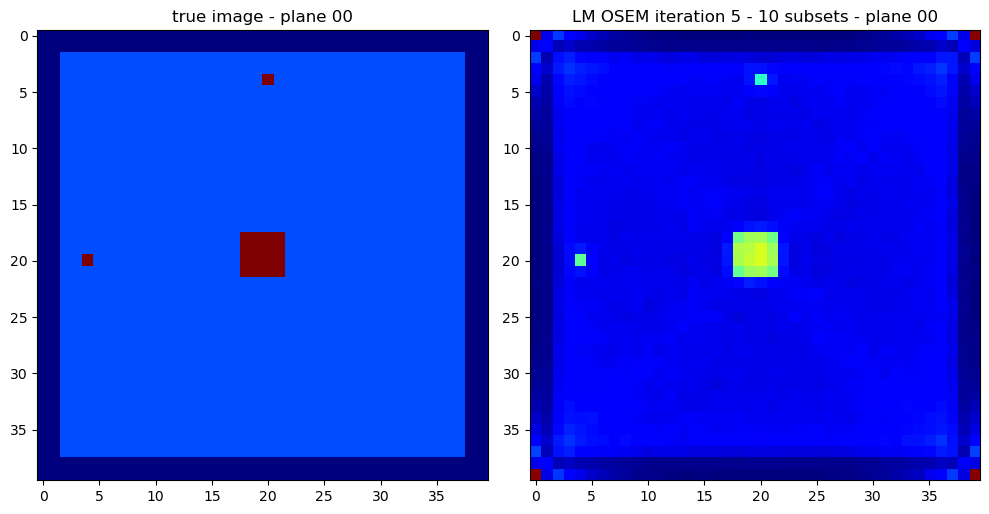

In [11]:
def _update_img(i):
    img0.set_data(x_true_np[:, :, i])
    img1.set_data(x_np[:, :, i])
    ax[0].set_title(f"true image - plane {i:02}")
    ax[1].set_title(
        f"LM OSEM iteration {num_iter} - {num_subsets} subsets - plane {i:02}"
    )
    return (img0, img1)


x_true_np = parallelproj.to_numpy_array(x_true)
x_np = parallelproj.to_numpy_array(x)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vmax = x_np.max()
img0 = ax[0].imshow(x_true_np[:, :, 2], cmap="jet")
img1 = ax[1].imshow(x_np[:, :, 2], cmap="jet")
print(x.size - xp.isnan(x).sum())
ax[0].set_title(f"true image - plane {0:02}")
ax[1].set_title(f"LM OSEM iteration {num_iter} - {num_subsets} subsets - plane {0:02}")
fig.tight_layout()
# ani = animation.FuncAnimation(fig, _update_img, x_np.shape[2], interval=200, blit=False)
fig.show()